In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [12]:
## Load dataset
data_path = "../../../Rings_P3"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
# STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
# MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
# ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
K = 4
MCMC_SIZE = 10
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 300
NUM_HIDDEN_LOCAL = 64
NUM_HIDDEN = 32
NUM_NSS = 8
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
DEVICE = 0

RECON_SIGMA = torch.ones(1) * 0.1
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'ag-4rings-p3-2run'

In [13]:
from global_oneshot_mu import *
from local_oneshot_state import *
from local_enc_angle import *
from global_enc_mu import *
from decoder_semi import *
# initialization
oneshot_mu = Oneshot_mu(K, D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
oneshot_state = Oneshot_state(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_angle = Enc_angle(D, NUM_HIDDEN, CUDA, DEVICE)
enc_mu = Enc_mu(K, D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
dec_x = Dec_x(D, NUM_HIDDEN, RECON_SIGMA, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        oneshot_mu.cuda()
        oneshot_state.cuda()
        enc_angle.cuda()
        enc_mu.cuda()
        dec_x.cuda()
optimizer =  torch.optim.Adam(list(dec_x.parameters())+list(oneshot_mu.parameters())+list(oneshot_state.parameters())+list(enc_mu.parameters())+list(enc_angle.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

models = (oneshot_mu, oneshot_state, enc_angle, enc_mu, dec_x)

In [14]:
oneshot_mu.load_state_dict(torch.load('../results/oneshot-mu-' + PATH))
oneshot_state.load_state_dict(torch.load('../results/oneshot-state-' + PATH))
enc_angle.load_state_dict(torch.load('../results/enc-angle-' + PATH))
enc_mu.load_state_dict(torch.load('../results/enc-mu-' + PATH))
dec_x.load_state_dict(torch.load('../results/dec-x-' + PATH))

In [ ]:
train(models, optimizer, OB, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, K, CUDA, DEVICE, PATH)

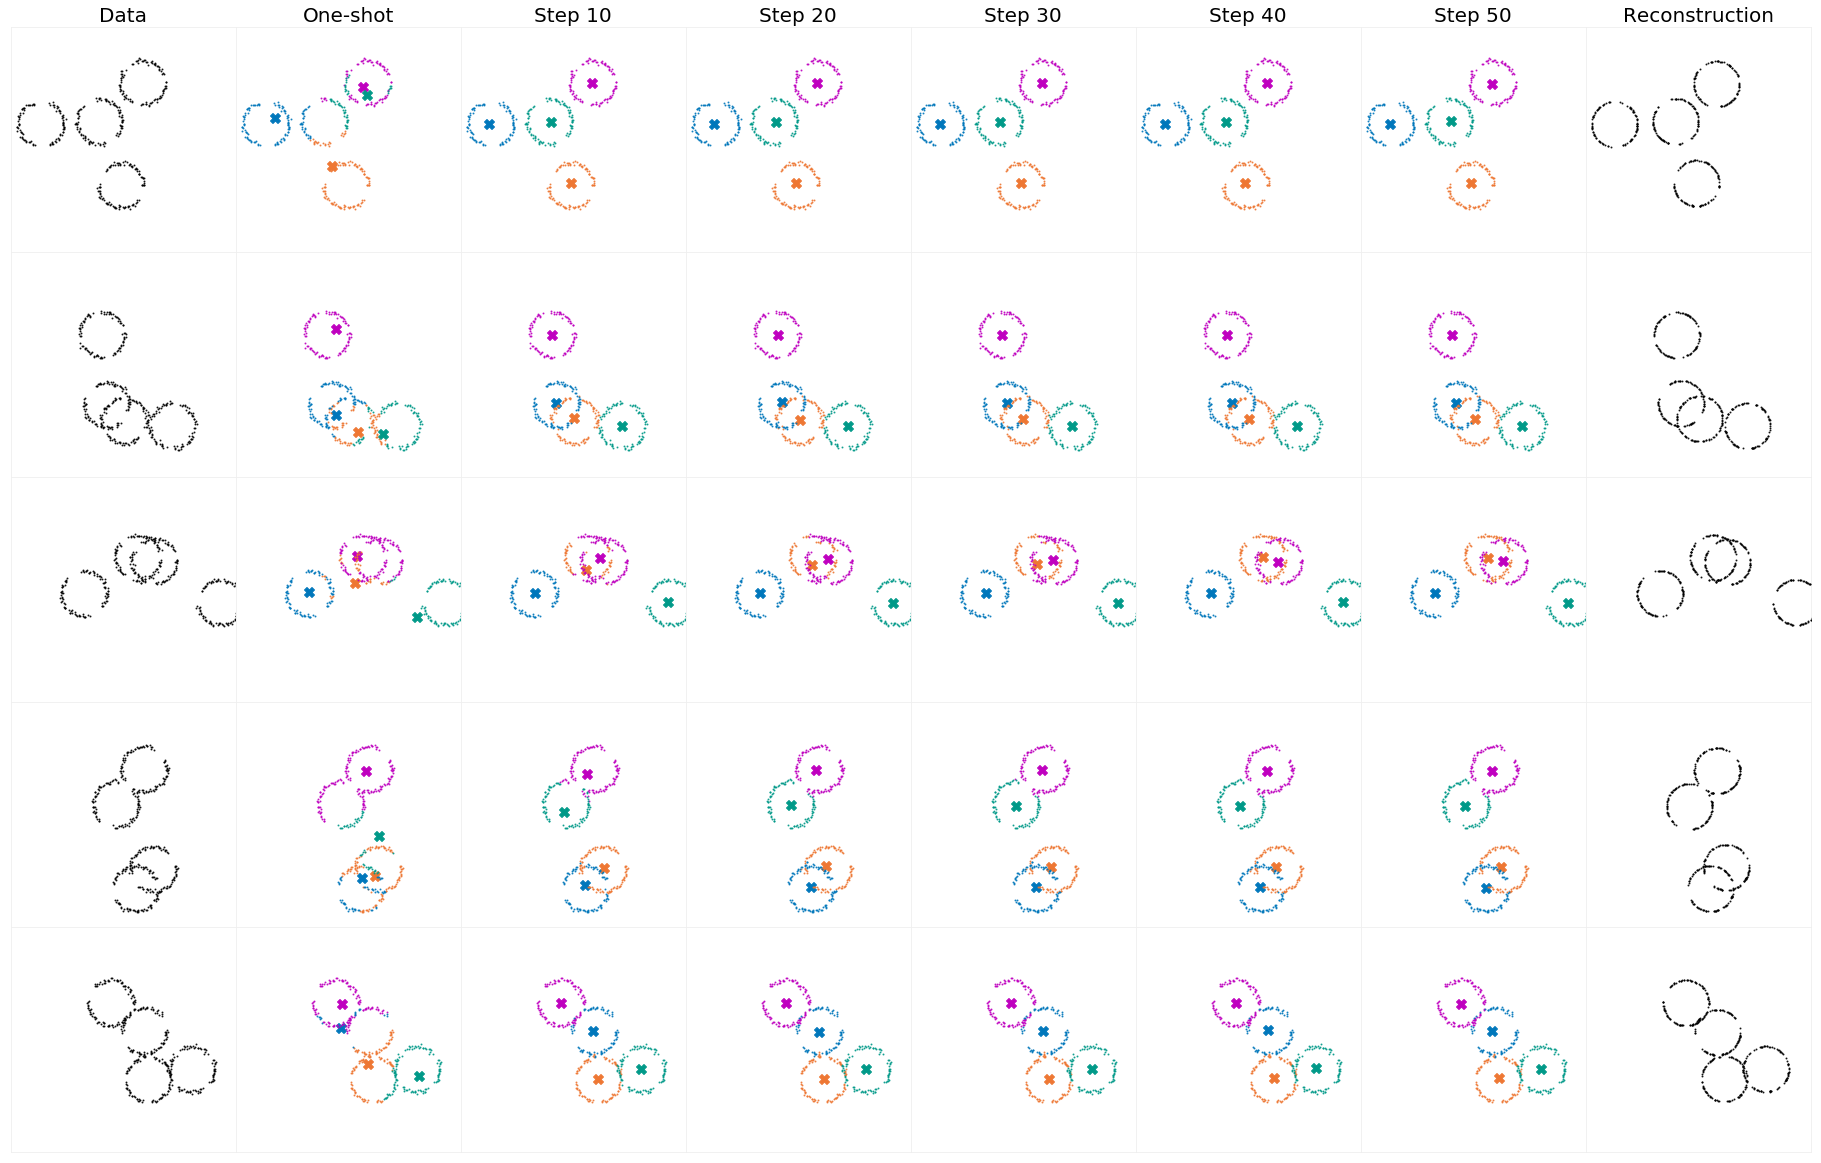

In [11]:
BATCH_SIZE = 5
MCMC_STEPS = 50 ## 12 is maximum mcmc steps
VIS_INTERVAL = 10
FS = 25
TITLE_FS = 20
OB_MS = 1.0
MU_MARKER = 'X'
MU_MS = 100
OPACITY = 0.8
BOUND = 10
COLORS = ['#EE7733', 'm', '#0077BB', '#009988']
##
DATA_PTR = 5

plot_obj = Plot_MC(BATCH_SIZE, MCMC_STEPS, VIS_INTERVAL, FS, TITLE_FS, OB_MS, MU_MARKER, MU_MS, OPACITY, BOUND, COLORS, CUDA, DEVICE)
plot_obj.plot_results(models, OB, K, DATA_PTR)
# plt.savefig('samples.png')

In [ ]:
torch.save(enc_angle.state_dict(), '../results/enc-angle-' + PATH)
torch.save(oneshot_mu.state_dict(), '../results/oneshot-mu-' + PATH)
torch.save(oneshot_state.state_dict(), '../results/oneshot-state-' + PATH)
torch.save(enc_mu.state_dict(), '../results/enc-mu-' + PATH)
torch.save(dec_x.state_dict(), '../results/dec-x-' + PATH)